The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install d2l==version


# Naive Bayes
:label:`sec_naive_bayes`

Throughout the previous sections, we learned about the theory of probability and random variables.  To put this theory to work, let us introduce the *naive Bayes* classifier.  This uses nothing but probabilistic fundamentals to allow us to perform classification of digits.

Learning is all about making assumptions. If we want to classify a new data point that we have never seen before we have to make some assumptions about which data points are similar to each other. The naive Bayes classifier, a popular and remarkably clear algorithm, assumes all features are independent from each other to simplify the computation. In this section, we will apply this model to recognize characters in images.


In [1]:
%matplotlib inline
from d2l import torch as d2l
import math
import torch
import torchvision
d2l.use_svg_display()

## Optical Character Recognition

MNIST :cite:`LeCun.Bottou.Bengio.ea.1998` is one of widely used datasets. It contains 60,000 images for training and 10,000 images for validation. Each image contains a handwritten digit from 0 to 9. The task is classifying each image into the corresponding digit.

Gluon provides a `MNIST` class in the `data.vision` module to
automatically retrieve the dataset from the Internet.
Subsequently, Gluon will use the already-downloaded local copy.
We specify whether we are requesting the training set or the test set
by setting the value of the parameter `train` to `True` or `False`, respectively.
Each image is a grayscale image with both width and height of $28$ with shape ($28$,$28$,$1$). We use a customized transformation to remove the last channel dimension. In addition, the dataset represents each pixel by an unsigned $8$-bit integer.  We quantize them into binary features to simplify the problem.


In [2]:
data_transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor()])

mnist_train = torchvision.datasets.MNIST(
    root='./temp', train=True, transform=data_transform, download=True)
mnist_test = torchvision.datasets.MNIST(
    root='./temp', train=False, transform=data_transform, download=True)

0.0%

0.1%

0.2%

0.2%

0.3%

0.4%

0.5%

0.6%

0.7%

0.7%

0.8%

0.9%

1.0%

1.1%

1.2%

1.2%

1.3%

1.4%

1.5%

1.6%

1.7%

1.7%

1.8%

1.9%

2.0%

2.1%

2.1%

2.2%

2.3%

2.4%

2.5%

2.6%

2.6%

2.7%

2.8%

2.9%

3.0%

3.1%

3.1%

3.2%

3.3%

3.4%

3.5%

3.6%

3.6%

3.7%

3.8%

3.9%

4.0%

4.0%

4.1%

4.2%

4.3%

4.4%

4.5%

4.5%

4.6%

4.7%

4.8%

4.9%

5.0%

5.0%

5.1%

5.2%

5.3%

5.4%

5.5%

5.5%

5.6%

5.7%

5.8%

5.9%

6.0%

6.0%

6.1%

6.2%

6.3%

6.4%

6.4%

6.5%

6.6%

6.7%

6.8%

6.9%

6.9%

7.0%

7.1%

7.2%

7.3%

7.4%

7.4%

7.5%

7.6%

7.7%

7.8%

7.9%

7.9%

8.0%

8.1%

8.2%

8.3%

8.3%

8.4%

8.5%

8.6%

8.7%

8.8%

8.8%

8.9%

9.0%

9.1%

9.2%

9.3%

9.3%

9.4%

9.5%

9.6%

9.7%

9.8%

9.8%

9.9%

10.0%

10.1%

10.2%

10.2%

10.3%

10.4%

10.5%

10.6%

10.7%

10.7%

10.8%

10.9%

11.0%

11.1%

11.2%

11.2%

11.3%

11.4%

11.5%

11.6%

11.7%

11.7%

11.8%

11.9%

12.0%

12.1%

12.1%

12.2%

12.3%

12.4%

12.5%

12.6%

12.6%

12.7%

12.8%

12.9%

13.0%

13.1%

13.1%

13.2%

13.3%

13.4%

13.5%

13.6%

13.6%

13.7%

13.8%

13.9%

14.0%

14.0%

14.1%

14.2%

14.3%

14.4%

14.5%

14.5%

14.6%

14.7%

14.8%

14.9%

15.0%

15.0%

15.1%

15.2%

15.3%

15.4%

15.5%

15.5%

15.6%

15.7%

15.8%

15.9%

16.0%

16.0%

16.1%

16.2%

16.3%

16.4%

16.4%

16.5%

16.6%

16.7%

16.8%

16.9%

16.9%

17.0%

17.1%

17.2%

17.3%

17.4%

17.4%

17.5%

17.6%

17.7%

17.8%

17.9%

17.9%

18.0%

18.1%

18.2%

18.3%

18.3%

18.4%

18.5%

18.6%

18.7%

18.8%

18.8%

18.9%

19.0%

19.1%

19.2%

19.3%

19.3%

19.4%

19.5%

19.6%

19.7%

19.8%

19.8%

19.9%

20.0%

20.1%

20.2%

20.2%

20.3%

20.4%

20.5%

20.6%

20.7%

20.7%

20.8%

20.9%

21.0%

21.1%

21.2%

21.2%

21.3%

21.4%

21.5%

21.6%

21.7%

21.7%

21.8%

21.9%

22.0%

22.1%

22.1%

22.2%

22.3%

22.4%

22.5%

22.6%

22.6%

22.7%

22.8%

22.9%

23.0%

23.1%

23.1%

23.2%

23.3%

23.4%

23.5%

23.6%

23.6%

23.7%

23.8%

23.9%

24.0%

24.0%

24.1%

24.2%

24.3%

24.4%

24.5%

24.5%

24.6%

24.7%

24.8%

24.9%

25.0%

25.0%

25.1%

25.2%

25.3%

25.4%

25.5%

25.5%

25.6%

25.7%

25.8%

25.9%

26.0%

26.0%

26.1%

26.2%

26.3%

26.4%

26.4%

26.5%

26.6%

26.7%

26.8%

26.9%

26.9%

27.0%

27.1%

27.2%

27.3%

27.4%

27.4%

27.5%

27.6%

27.7%

27.8%

27.9%

27.9%

28.0%

28.1%

28.2%

28.3%

28.3%

28.4%

28.5%

28.6%

28.7%

28.8%

28.8%

28.9%

29.0%

29.1%

29.2%

29.3%

29.3%

29.4%

29.5%

29.6%

29.7%

29.8%

29.8%

29.9%

30.0%

30.1%

30.2%

30.2%

30.3%

30.4%

30.5%

30.6%

30.7%

30.7%

30.8%

30.9%

31.0%

31.1%

31.2%

31.2%

31.3%

31.4%

31.5%

31.6%

31.7%

31.7%

31.8%

31.9%

32.0%

32.1%

32.1%

32.2%

32.3%

32.4%

32.5%

32.6%

32.6%

32.7%

32.8%

32.9%

33.0%

33.1%

33.1%

33.2%

33.3%

33.4%

33.5%

33.6%

33.6%

33.7%

33.8%

33.9%

34.0%

34.0%

34.1%

34.2%

34.3%

34.4%

34.5%

34.5%

34.6%

34.7%

34.8%

34.9%

35.0%

35.0%

35.1%

35.2%

35.3%

35.4%

35.5%

35.5%

35.6%

35.7%

35.8%

35.9%

36.0%

36.0%

36.1%

36.2%

36.3%

36.4%

36.4%

36.5%

36.6%

36.7%

36.8%

36.9%

36.9%

37.0%

37.1%

37.2%

37.3%

37.4%

37.4%

37.5%

37.6%

37.7%

37.8%

37.9%

37.9%

38.0%

38.1%

38.2%

38.3%

38.3%

38.4%

38.5%

38.6%

38.7%

38.8%

38.8%

38.9%

39.0%

39.1%

39.2%

39.3%

39.3%

39.4%

39.5%

39.6%

39.7%

39.8%

39.8%

39.9%

40.0%

40.1%

40.2%

40.2%

40.3%

40.4%

40.5%

40.6%

40.7%

40.7%

40.8%

40.9%

41.0%

41.1%

41.2%

41.2%

41.3%

41.4%

41.5%

41.6%

41.7%

41.7%

41.8%

41.9%

42.0%

42.1%

42.1%

42.2%

42.3%

42.4%

42.5%

42.6%

42.6%

42.7%

42.8%

42.9%

43.0%

43.1%

43.1%

43.2%

43.3%

43.4%

43.5%

43.6%

43.6%

43.7%

43.8%

43.9%

44.0%

44.0%

44.1%

44.2%

44.3%

44.4%

44.5%

44.5%

44.6%

44.7%

44.8%

44.9%

45.0%

45.0%

45.1%

45.2%

45.3%

45.4%

45.5%

45.5%

45.6%

45.7%

45.8%

45.9%

45.9%

46.0%

46.1%

46.2%

46.3%

46.4%

46.4%

46.5%

46.6%

46.7%

46.8%

46.9%

46.9%

47.0%

47.1%

47.2%

47.3%

47.4%

47.4%

47.5%

47.6%

47.7%

47.8%

47.9%

47.9%

48.0%

48.1%

48.2%

48.3%

48.3%

48.4%

48.5%

48.6%

48.7%

48.8%

48.8%

48.9%

49.0%

49.1%

49.2%

49.3%

49.3%

49.4%

49.5%

49.6%

49.7%

49.8%

49.8%

49.9%

50.0%

50.1%

50.2%

50.2%

50.3%

50.4%

50.5%

50.6%

50.7%

50.7%

50.8%

50.9%

51.0%

51.1%

51.2%

51.2%

51.3%

51.4%

51.5%

51.6%

51.7%

51.7%

51.8%

51.9%

52.0%

52.1%

52.1%

52.2%

52.3%

52.4%

52.5%

52.6%

52.6%

52.7%

52.8%

52.9%

53.0%

53.1%

53.1%

53.2%

53.3%

53.4%

53.5%

53.6%

53.6%

53.7%

53.8%

53.9%

54.0%

54.0%

54.1%

54.2%

54.3%

54.4%

54.5%

54.5%

54.6%

54.7%

54.8%

54.9%

55.0%

55.0%

55.1%

55.2%

55.3%

55.4%

55.5%

55.5%

55.6%

55.7%

55.8%

55.9%

55.9%

56.0%

56.1%

56.2%

56.3%

56.4%

56.4%

56.5%

56.6%

56.7%

56.8%

56.9%

56.9%

57.0%

57.1%

57.2%

57.3%

57.4%

57.4%

57.5%

57.6%

57.7%

57.8%

57.9%

57.9%

58.0%

58.1%

58.2%

58.3%

58.3%

58.4%

58.5%

58.6%

58.7%

58.8%

58.8%

58.9%

59.0%

59.1%

59.2%

59.3%

59.3%

59.4%

59.5%

59.6%

59.7%

59.8%

59.8%

59.9%

60.0%

60.1%

60.2%

60.2%

60.3%

60.4%

60.5%

60.6%

60.7%

60.7%

60.8%

60.9%

61.0%

61.1%

61.2%

61.2%

61.3%

61.4%

61.5%

61.6%

61.7%

61.7%

61.8%

61.9%

62.0%

62.1%

62.1%

62.2%

62.3%

62.4%

62.5%

62.6%

62.6%

62.7%

62.8%

62.9%

63.0%

63.1%

63.1%

63.2%

63.3%

63.4%

63.5%

63.6%

63.6%

63.7%

63.8%

63.9%

64.0%

64.0%

64.1%

64.2%

64.3%

64.4%

64.5%

64.5%

64.6%

64.7%

64.8%

64.9%

65.0%

65.0%

65.1%

65.2%

65.3%

65.4%

65.5%

65.5%

65.6%

65.7%

65.8%

65.9%

65.9%

66.0%

66.1%

66.2%

66.3%

66.4%

66.4%

66.5%

66.6%

66.7%

66.8%

66.9%

66.9%

67.0%

67.1%

67.2%

67.3%

67.4%

67.4%

67.5%

67.6%

67.7%

67.8%

67.9%

67.9%

68.0%

68.1%

68.2%

68.3%

68.3%

68.4%

68.5%

68.6%

68.7%

68.8%

68.8%

68.9%

69.0%

69.1%

69.2%

69.3%

69.3%

69.4%

69.5%

69.6%

69.7%

69.8%

69.8%

69.9%

70.0%

70.1%

70.2%

70.2%

70.3%

70.4%

70.5%

70.6%

70.7%

70.7%

70.8%

70.9%

71.0%

71.1%

71.2%

71.2%

71.3%

71.4%

71.5%

71.6%

71.7%

71.7%

71.8%

71.9%

72.0%

72.1%

72.1%

72.2%

72.3%

72.4%

72.5%

72.6%

72.6%

72.7%

72.8%

72.9%

73.0%

73.1%

73.1%

73.2%

73.3%

73.4%

73.5%

73.6%

73.6%

73.7%

73.8%

73.9%

74.0%

74.0%

74.1%

74.2%

74.3%

74.4%

74.5%

74.5%

74.6%

74.7%

74.8%

74.9%

75.0%

75.0%

75.1%

75.2%

75.3%

75.4%

75.5%

75.5%

75.6%

75.7%

75.8%

75.9%

75.9%

76.0%

76.1%

76.2%

76.3%

76.4%

76.4%

76.5%

76.6%

76.7%

76.8%

76.9%

76.9%

77.0%

77.1%

77.2%

77.3%

77.4%

77.4%

77.5%

77.6%

77.7%

77.8%

77.9%

77.9%

78.0%

78.1%

78.2%

78.3%

78.3%

78.4%

78.5%

78.6%

78.7%

78.8%

78.8%

78.9%

79.0%

79.1%

79.2%

79.3%

79.3%

79.4%

79.5%

79.6%

79.7%

79.8%

79.8%

79.9%

80.0%

80.1%

80.2%

80.2%

80.3%

80.4%

80.5%

80.6%

80.7%

80.7%

80.8%

80.9%

81.0%

81.1%

81.2%

81.2%

81.3%

81.4%

81.5%

81.6%

81.7%

81.7%

81.8%

81.9%

82.0%

82.1%

82.1%

82.2%

82.3%

82.4%

82.5%

82.6%

82.6%

82.7%

82.8%

82.9%

83.0%

83.1%

83.1%

83.2%

83.3%

83.4%

83.5%

83.6%

83.6%

83.7%

83.8%

83.9%

84.0%

84.0%

84.1%

84.2%

84.3%

84.4%

84.5%

84.5%

84.6%

84.7%

84.8%

84.9%

85.0%

85.0%

85.1%

85.2%

85.3%

85.4%

85.5%

85.5%

85.6%

85.7%

85.8%

85.9%

85.9%

86.0%

86.1%

86.2%

86.3%

86.4%

86.4%

86.5%

86.6%

86.7%

86.8%

86.9%

86.9%

87.0%

87.1%

87.2%

87.3%

87.4%

87.4%

87.5%

87.6%

87.7%

87.8%

87.9%

87.9%

88.0%

88.1%

88.2%

88.3%

88.3%

88.4%

88.5%

88.6%

88.7%

88.8%

88.8%

88.9%

89.0%

89.1%

89.2%

89.3%

89.3%

89.4%

89.5%

89.6%

89.7%

89.8%

89.8%

89.9%

90.0%

90.1%

90.2%

90.2%

90.3%

90.4%

90.5%

90.6%

90.7%

90.7%

90.8%

90.9%

91.0%

91.1%

91.2%

91.2%

91.3%

91.4%

91.5%

91.6%

91.7%

91.7%

91.8%

91.9%

92.0%

92.1%

92.1%

92.2%

92.3%

92.4%

92.5%

92.6%

92.6%

92.7%

92.8%

92.9%

93.0%

93.1%

93.1%

93.2%

93.3%

93.4%

93.5%

93.6%

93.6%

93.7%

93.8%

93.9%

94.0%

94.0%

94.1%

94.2%

94.3%

94.4%

94.5%

94.5%

94.6%

94.7%

94.8%

94.9%

95.0%

95.0%

95.1%

95.2%

95.3%

95.4%

95.5%

95.5%

95.6%

95.7%

95.8%

95.9%

95.9%

96.0%

96.1%

96.2%

96.3%

96.4%

96.4%

96.5%

96.6%

96.7%

96.8%

96.9%

96.9%

97.0%

97.1%

97.2%

97.3%

97.4%

97.4%

97.5%

97.6%

97.7%

97.8%

97.9%

97.9%

98.0%

98.1%

98.2%

98.3%

98.3%

98.4%

98.5%

98.6%

98.7%

98.8%

98.8%

98.9%

99.0%

99.1%

99.2%

99.3%

99.3%

99.4%

99.5%

99.6%

99.7%

99.8%

99.8%

99.9%

100.0%

100.1%

Extracting ./temp/MNIST/raw/train-images-idx3-ubyte.gz to ./temp/MNIST/raw


0.0%

28.4%

56.7%

85.1%

113.5%

Extracting ./temp/MNIST/raw/train-labels-idx1-ubyte.gz to ./temp/MNIST/raw


0.0%

0.5%

1.0%

1.5%

2.0%

2.5%

3.0%

3.5%

4.0%

4.5%

5.0%

5.5%

6.0%

6.5%

7.0%

7.5%

7.9%

8.4%

8.9%

9.4%

9.9%

10.4%

10.9%

11.4%

11.9%

12.4%

12.9%

13.4%

13.9%

14.4%

14.9%

15.4%

15.9%

16.4%

16.9%

17.4%

17.9%

18.4%

18.9%

19.4%

19.9%

20.4%

20.9%

21.4%

21.9%

22.4%

22.9%

23.4%

23.8%

24.3%

24.8%

25.3%

25.8%

26.3%

26.8%

27.3%

27.8%

28.3%

28.8%

29.3%

29.8%

30.3%

30.8%

31.3%

31.8%

32.3%

32.8%

33.3%

33.8%

34.3%

34.8%

35.3%

35.8%

36.3%

36.8%

37.3%

37.8%

38.3%

38.8%

39.2%

39.7%

40.2%

40.7%

41.2%

41.7%

42.2%

42.7%

43.2%

43.7%

44.2%

44.7%

45.2%

45.7%

46.2%

46.7%

47.2%

47.7%

48.2%

48.7%

49.2%

49.7%

50.2%

50.7%

51.2%

51.7%

52.2%

52.7%

53.2%

53.7%

54.2%

54.7%

55.1%

55.6%

56.1%

56.6%

57.1%

57.6%

58.1%

58.6%

59.1%

59.6%

60.1%

60.6%

61.1%

61.6%

62.1%

62.6%

63.1%

63.6%

64.1%

64.6%

65.1%

65.6%

66.1%

66.6%

67.1%

67.6%

68.1%

68.6%

69.1%

69.6%

70.1%

70.5%

71.0%

71.5%

72.0%

72.5%

73.0%

73.5%

74.0%

74.5%

75.0%

75.5%

76.0%

76.5%

77.0%

77.5%

78.0%

78.5%

79.0%

79.5%

80.0%

80.5%

81.0%

81.5%

82.0%

82.5%

83.0%

83.5%

84.0%

84.5%

85.0%

85.5%

86.0%

86.4%

86.9%

87.4%

87.9%

88.4%

88.9%

89.4%

89.9%

90.4%

90.9%

91.4%

91.9%

92.4%

92.9%

93.4%

93.9%

94.4%

94.9%

95.4%

95.9%

96.4%

96.9%

97.4%

97.9%

98.4%

98.9%

99.4%

99.9%

100.4%

Extracting ./temp/MNIST/raw/t10k-images-idx3-ubyte.gz to ./temp/MNIST/raw


0.0%

180.4%

Extracting ./temp/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./temp/MNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


We can access a particular example, which contains the image and the corresponding label.


In [3]:
image, label = mnist_train[2]
image.shape, label

(torch.Size([1, 28, 28]), 4)

Our example, stored here in the variable `image`, corresponds to an image with a height and width of $28$ pixels.


In [4]:
image.shape, image.dtype

(torch.Size([1, 28, 28]), torch.float32)

Our code stores the label of each image as a scalar. Its type is a $32$-bit integer.


In [5]:
label, type(label)

(4, int)

We can also access multiple examples at the same time.


In [6]:
images = torch.stack([mnist_train[i][0] for i in range(10,38)], 
                     dim=1).squeeze(0)
labels = torch.tensor([mnist_train[i][1] for i in range(10,38)])
images.shape, labels.shape

(torch.Size([28, 28, 28]), torch.Size([28]))

Let us visualize these examples.


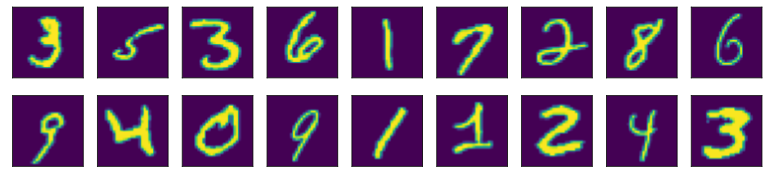

In [7]:
d2l.show_images(images, 2, 9);

## The Probabilistic Model for Classification

In a classification task, we map an example into a category. Here an example is a grayscale $28\times 28$ image, and a category is a digit. (Refer to :numref:`sec_softmax` for a more detailed explanation.)
One natural way to express the classification task is via the probabilistic question: what is the most likely label given the features (i.e., image pixels)? Denote by $\mathbf x\in\mathbb R^d$ the features of the example and $y\in\mathbb R$ the label. Here features are image pixels, where we can reshape a $2$-dimensional image to a vector so that $d=28^2=784$, and labels are digits.
The probability of the label given the features is $p(y  \mid  \mathbf{x})$. If we are able to compute these probabilities, which are $p(y  \mid  \mathbf{x})$ for $y=0, \ldots,9$ in our example, then the classifier will output the prediction $\hat{y}$ given by the expression:

$$\hat{y} = \mathrm{argmax} \> p(y  \mid  \mathbf{x}).$$

Unfortunately, this requires that we estimate $p(y  \mid  \mathbf{x})$ for every value of $\mathbf{x} = x_1, ..., x_d$. Imagine that each feature could take one of $2$ values. For example, the feature $x_1 = 1$ might signify that the word apple appears in a given document and $x_1 = 0$ would signify that it does not. If we had $30$ such binary features, that would mean that we need to be prepared to classify any of $2^{30}$ (over 1 billion!) possible values of the input vector $\mathbf{x}$.

Moreover, where is the learning? If we need to see every single possible example in order to predict the corresponding label then we are not really learning a pattern but just memorizing the dataset.

## The Naive Bayes Classifier

Fortunately, by making some assumptions about conditional independence, we can introduce some inductive bias and build a model capable of generalizing from a comparatively modest selection of training examples. To begin, let us use Bayes theorem, to express the classifier as

$$\hat{y} = \mathrm{argmax}_y \> p(y  \mid  \mathbf{x}) = \mathrm{argmax}_y \> \frac{p( \mathbf{x}  \mid  y) p(y)}{p(\mathbf{x})}.$$

Note that the denominator is the normalizing term $p(\mathbf{x})$ which does not depend on the value of the label $y$. As a result, we only need to worry about comparing the numerator across different values of $y$. Even if calculating the denominator turned out to be intractable, we could get away with ignoring it, so long as we could evaluate the numerator. Fortunately, even if we wanted to recover the normalizing constant, we could.  We can always recover the normalization term since $\sum_y p(y  \mid  \mathbf{x}) = 1$.

Now, let us focus on $p( \mathbf{x}  \mid  y)$. Using the chain rule of probability, we can express the term $p( \mathbf{x}  \mid  y)$ as

$$p(x_1  \mid y) \cdot p(x_2  \mid  x_1, y) \cdot ... \cdot p( x_d  \mid  x_1, ..., x_{d-1}, y).$$

By itself, this expression does not get us any further. We still must estimate roughly $2^d$ parameters. However, if we assume that *the features are conditionally independent of each other, given the label*, then suddenly we are in much better shape, as this term simplifies to $\prod_i p(x_i  \mid  y)$, giving us the predictor

$$ \hat{y} = \mathrm{argmax}_y \> \prod_{i=1}^d p(x_i  \mid  y) p(y).$$

If we can estimate $\prod_i p(x_i=1  \mid  y)$ for every $i$ and $y$, and save its value in $P_{xy}[i, y]$, here $P_{xy}$ is a $d\times n$ matrix with $n$ being the number of classes and $y\in\{1, \ldots, n\}$. In addition, we estimate $p(y)$ for every $y$ and save it in $P_y[y]$, with $P_y$ a $n$-length vector. Then for any new example $\mathbf x$, we could compute

$$ \hat{y} = \mathrm{argmax}_y \> \prod_{i=1}^d P_{xy}[x_i, y]P_y[y],$$
:eqlabel:`eq_naive_bayes_estimation`

for any $y$. So our assumption of conditional independence has taken the complexity of our model from an exponential dependence on the number of features $\mathcal{O}(2^dn)$ to a linear dependence, which is $\mathcal{O}(dn)$.


## Training

The problem now is that we do not know $P_{xy}$ and $P_y$. So we need to estimate their values given some training data first. This is *training* the model. Estimating $P_y$ is not too hard. Since we are only dealing with $10$ classes, we may count the number of occurrences $n_y$ for each of the digits and divide it by the total amount of data $n$. For instance, if digit 8 occurs $n_8 = 5,800$ times and we have a total of $n = 60,000$ images, the probability estimate is $p(y=8) = 0.0967$.


In [8]:
X = torch.stack([mnist_train[i][0] for i in range(len(mnist_train))], 
                dim=1).squeeze(0)
Y = torch.tensor([mnist_train[i][1] for i in range(len(mnist_train))])

n_y = torch.zeros(10)
for y in range(10):
    n_y[y] = (Y == y).sum()
P_y = n_y / n_y.sum()
P_y

tensor([0.0987, 0.1124, 0.0993, 0.1022, 0.0974, 0.0904, 0.0986, 0.1044, 0.0975,
        0.0992])

Now on to slightly more difficult things $P_{xy}$. Since we picked black and white images, $p(x_i  \mid  y)$ denotes the probability that pixel $i$ is switched on for class $y$. Just like before we can go and count the number of times $n_{iy}$ such that an event occurs and divide it by the total number of occurrences of $y$, i.e., $n_y$. But there is something slightly troubling: certain pixels may never be black (e.g., for well cropped images the corner pixels might always be white). A convenient way for statisticians to deal with this problem is to add pseudo counts to all occurrences. Hence, rather than $n_{iy}$ we use $n_{iy}+1$ and instead of $n_y$ we use $n_{y} + 1$. This is also called *Laplace Smoothing*.  It may seem ad-hoc, however it may be well motivated from a Bayesian point-of-view.


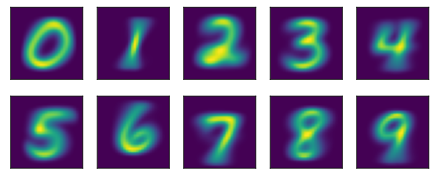

In [9]:
n_x = torch.zeros((10, 28, 28))
for y in range(10):
    n_x[y] = torch.tensor(X.numpy()[Y.numpy() == y].sum(axis=0))
P_xy = (n_x + 1) / (n_y + 1).reshape(10, 1, 1)

d2l.show_images(P_xy, 2, 5);

By visualizing these $10\times 28\times 28$ probabilities (for each pixel for each class) we could get some mean looking digits.

Now we can use :eqref:`eq_naive_bayes_estimation` to predict a new image. Given $\mathbf x$, the following functions computes $p(\mathbf x \mid y)p(y)$ for every $y$.


In [10]:
def bayes_pred(x):
    x = x.unsqueeze(0)  # (28, 28) -> (1, 28, 28)
    p_xy = P_xy * x + (1 - P_xy)*(1 - x)
    p_xy = p_xy.reshape(10, -1).prod(dim=1)  # p(x|y)
    return p_xy * P_y

image, label = mnist_test[0]
bayes_pred(image)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

This went horribly wrong! To find out why, let us look at the per pixel probabilities. They are typically numbers between $0.001$ and $1$. We are multiplying $784$ of them. At this point it is worth mentioning that we are calculating these numbers on a computer, hence with a fixed range for the exponent. What happens is that we experience *numerical underflow*, i.e., multiplying all the small numbers leads to something even smaller until it is rounded down to zero.  We discussed this as a theoretical issue in :numref:`sec_maximum_likelihood`, but we see the phenomena clearly here in practice.

As discussed in that section, we fix this by use the fact that $\log a b = \log a + \log b$, i.e., we switch to summing logarithms.
Even if both $a$ and $b$ are small numbers, the logarithm values should be in a proper range.


In [11]:
a = 0.1
print('underflow:', a**784)
print('logarithm is normal:', 784*math.log(a))

underflow: 0.0
logarithm is normal: -1805.2267129073316


Since the logarithm is an increasing function, we can rewrite :eqref:`eq_naive_bayes_estimation` as

$$ \hat{y} = \mathrm{argmax}_y \> \sum_{i=1}^d \log P_{xy}[x_i, y] + \log P_y[y].$$

We can implement the following stable version:


In [12]:
log_P_xy = torch.log(P_xy)
log_P_xy_neg = torch.log(1 - P_xy)
log_P_y = torch.log(P_y)

def bayes_pred_stable(x):
    x = x.unsqueeze(0)  # (28, 28) -> (1, 28, 28)
    p_xy = log_P_xy * x + log_P_xy_neg * (1 - x)
    p_xy = p_xy.reshape(10, -1).sum(axis=1)  # p(x|y)
    return p_xy + log_P_y

py = bayes_pred_stable(image)
py

tensor([-274.1816, -302.0446, -254.1889, -223.6054, -199.4293, -212.9662,
        -298.5675, -119.8299, -223.9704, -169.0555])

We may now check if the prediction is correct.


In [13]:
py.argmax(dim=0) == label

tensor(True)

If we now predict a few validation examples, we can see the Bayes
classifier works pretty well.


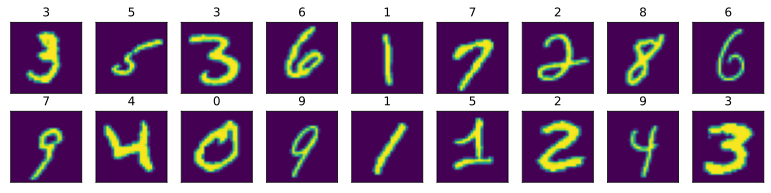

In [14]:
def predict(X):
    return [bayes_pred_stable(x).argmax(dim=0).type(torch.int32).item() 
            for x in X]

X = torch.stack([mnist_train[i][0] for i in range(10,38)], dim=1).squeeze(0)
y = torch.tensor([mnist_train[i][1] for i in range(10,38)])
preds = predict(X)
d2l.show_images(X, 2, 9, titles=[str(d) for d in preds]);

Finally, let us compute the overall accuracy of the classifier.


In [15]:
X = torch.stack([mnist_train[i][0] for i in range(len(mnist_test))], 
                dim=1).squeeze(0)
y = torch.tensor([mnist_train[i][1] for i in range(len(mnist_test))])
preds = torch.tensor(predict(X), dtype=torch.int32)
float((preds == y).sum()) / len(y)  # Validation accuracy

0.8364

Modern deep networks achieve error rates of less than $0.01$. The relatively poor performance is due to the incorrect statistical assumptions that we made in our model: we assumed that each and every pixel are *independently* generated, depending only on the label. This is clearly not how humans write digits, and this wrong assumption led to the downfall of our overly naive (Bayes) classifier.

## Summary
* Using Bayes' rule, a classifier can be made by assuming all observed features are independent.  
* This classifier can be trained on a dataset by counting the number of occurrences of combinations of labels and pixel values.
* This classifier was the gold standard for decades for tasks such as spam detection.

## Exercises
1. Consider the dataset $[[0,0], [0,1], [1,0], [1,1]]$ with labels given by the XOR of the two elements $[0,1,1,0]$.  What are the probabilities for a Naive Bayes classifier built on this dataset.  Does it successfully classify our points?  If not, what assumptions are violated?
1. Suppose that we did not use Laplace smoothing when estimating probabilities and a data point arrived at testing time which contained a value never observed in training.  What would the model output?
1. The naive Bayes classifier is a specific example of a Bayesian network, where the dependence of random variables are encoded with a graph structure.  While the full theory is beyond the scope of this section (see :cite:`Koller.Friedman.2009` for full details), explain why allowing explicit dependence between the two input variables in the XOR model allows for the creation of a successful classifier.
